In [10]:
import os

import xarray as xr
import numpy as np
import torch
from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc

from WD.datasets import Conditional_Dataset

import matplotlib
import matplotlib.pyplot as plt

import copy
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes

import cartopy.crs as ccrs
from datetime import datetime

In [11]:
lead_times = np.arange(6,78,6)

In [11]:
for lead_time in lead_times:
    os.system("sbatch submit_script_1_dataset_creation.sh -p /data/compoundx/WeatherDiff/config_file/template_geopotential_500_{}h.yml".format(lead_time))

Submitted batch job 42451513
Submitted batch job 42451514
Submitted batch job 42451515
Submitted batch job 42451516
Submitted batch job 42451517
Submitted batch job 42451518
Submitted batch job 42451519
Submitted batch job 42451520
Submitted batch job 42451521
Submitted batch job 42451522
Submitted batch job 42451523
Submitted batch job 42451524


In [12]:
dataset_ids = ["3DCF19", "87ED54", "1437FF", "68564B", "EED9AE", "3957A8", "6D01EA", "4DB338", "7FDD24", "FB7247", "6CFBE7", "EC71E2"]

In [4]:
for did in dataset_ids:
    os.system("sbatch submit_script_5_lr_schedule_selection.sh -d {} -l {}".format(did, "CosineAnnealingLR"))

Submitted batch job 42452229
Submitted batch job 42452230
Submitted batch job 42452231
Submitted batch job 42452232
Submitted batch job 42452233
Submitted batch job 42452234
Submitted batch job 42452235
Submitted batch job 42452236
Submitted batch job 42452237
Submitted batch job 42452238
Submitted batch job 42452239
Submitted batch job 42452240


In [13]:
model_ids = {
    "3DCF19": "7F6D6D",
    "87ED54": "772AA4",
    "1437FF": "1730B4",
    "68564B": "E0B046",
    "EED9AE": "6EFC3E",
    "3957A8": "2074B4",
    "6D01EA": "813C5B",
    "4DB338": "6B5907",
    "7FDD24": "EF0EED",
    "FB7247": "EDFE3D",
    "6CFBE7": "5F23D6",
    "EC71E2": "D767A6"
}

In [8]:
for did, mid in model_ids.items():
    print(did, mid)
    os.system("sbatch submit_script_3_eval.sh -d {} -m {} -e {}".format(did, mid, 1))

87ED54 772AA4
Submitted batch job 42527639
3DCF19 7F6D6D
Submitted batch job 42527640
1437FF 1730B4
Submitted batch job 42527641
68564B E0B046
Submitted batch job 42527642
EED9AE 6EFC3E
Submitted batch job 42527643
3957A8 2074B4
Submitted batch job 42527644
6D01EA 813C5B
Submitted batch job 42527645
4DB338 6B5907
Submitted batch job 42527646
7FDD24 EF0EED
Submitted batch job 42527647
FB7247 EDFE3D
Submitted batch job 42527648
6CFBE7 5F23D6
Submitted batch job 42527649
EC71E2 D767A6
Submitted batch job 42527650


In [14]:
predictions_experiments = {}
targets_experiments = {}


for did, mid in model_ids.items():
    predictions_experiments[mid] = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{did}/{mid}_gen.nc")
    targets_experiments[mid] = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{did}/{mid}_target.nc")

In [15]:
rmse = {}

data_ours = np.zeros((len(lead_times),2))
for i, model_id in enumerate(model_ids.values()):
    rmse[model_id] = compute_weighted_rmse(predictions_experiments[model_id].isel({"ensemble_member":0}), targets_experiments[model_id].isel({"ensemble_member":0}))
    print("lead_time: {}h, RMSE is {:.1f}".format(lead_times[i], rmse[model_id].z_500.values))
    data_ours[i,0] = lead_times[i] / 24
    data_ours[i,1] = rmse[model_id].z_500

lead_time: 6h, RMSE is 70.6
lead_time: 12h, RMSE is 106.6
lead_time: 18h, RMSE is 141.6
lead_time: 24h, RMSE is 183.0
lead_time: 30h, RMSE is 234.3
lead_time: 36h, RMSE is 292.2
lead_time: 42h, RMSE is 351.3
lead_time: 48h, RMSE is 401.7
lead_time: 54h, RMSE is 462.9
lead_time: 60h, RMSE is 528.7
lead_time: 66h, RMSE is 583.1
lead_time: 72h, RMSE is 632.7


In [16]:
# extracted from Rasp & Thuerey paper with https://automeris.io/WebPlotDigitizer/

data_ifs_baseline = np.array([0.00013954007590988304, 28.225806451612925,
                              0.2546561372426164, 27.419354838709637,
                              0.489141981577109, 37.90322580645159,
                              0.7470210444439642, 39.51612903225805,
                              0.9915582755367345, 50.80645161290329,
                              1.2394039568163977, 54.83870967741939,
                              1.5140998494767695, 69.35483870967744,
                              1.7284739177091664, 76.61290322580646,
                              1.9931229249040323, 91.12903225806451,
                              2.2577629295133557, 104.03225806451621,
                              2.5291368681085205, 123.38709677419354,
                              2.753580328270279, 134.67741935483878,
                              3.0015070328198252, 153.22580645161293,
                              3.2527691953128937, 169.35483870967744,
                              3.5174632154354724, 191.9354838709677,
                              3.741942685939401, 209.67741935483866,
                              3.9966123270603315, 236.29032258064512,
                              4.234496647437144, 255.64516129032256,
                              4.502557634552643, 281.45161290322585,
                              4.750515848151588, 305.64516129032256,
                              5.001850031328997, 334.67741935483866])

data_rasp_thuerey_best = np.array([5.009592254895605, 521.7741935483871, 
3.0088351374514755, 266.1290322580645, 
0.9951232994115908, 89.51612903225805, 
0.2514647206677758, 55.64516129032256])


data_ifs_baseline = data_ifs_baseline.reshape(-1,2)
data_ifs_baseline[:,0] = data_ifs_baseline[:,0]

data_rasp_thuerey_best = data_rasp_thuerey_best.reshape(-1,2)
data_rasp_thuerey_best[:,0] = data_rasp_thuerey_best[:,0]


data_direct_cnn = np.array([[3,626], [5,757]])

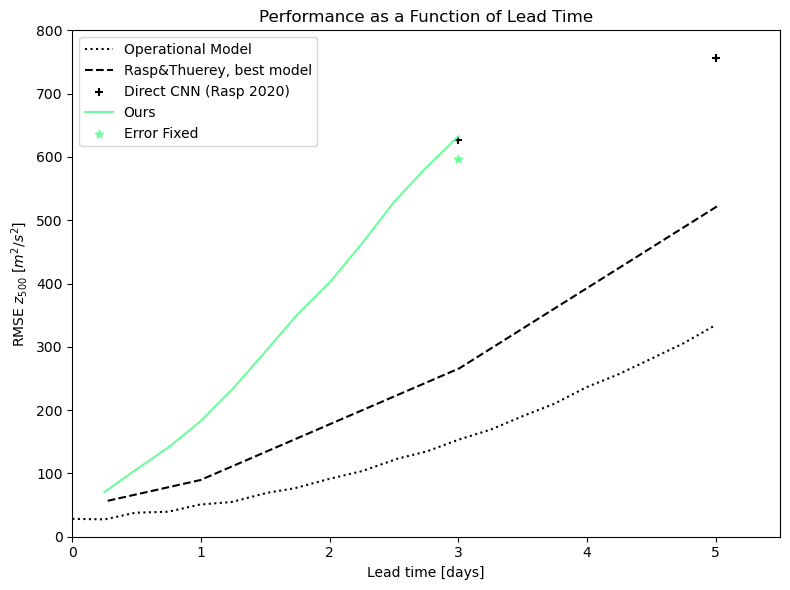

In [23]:
plt.figure(figsize=(8,6))
plt.plot(data_ifs_baseline[:,0], data_ifs_baseline[:,1], label="Operational Model", color="k", linestyle="dotted")
plt.plot(data_rasp_thuerey_best[:,0], data_rasp_thuerey_best[:,1], label="Rasp&Thuerey, best model", color="k", linestyle="dashed")
plt.scatter(data_direct_cnn[:,0], data_direct_cnn[:,1], label="Direct CNN (Rasp 2020)", color="k",marker="+")
plt.plot(data_ours[:,0], data_ours[:,1], label="Ours", color="#6cfc9c")

plt.scatter([3,], [596.3,], label="Error Fixed", color="#6cfc9c", marker="*")

plt.ylabel("RMSE $z_{500}$ $[m^2/s^2]$")
plt.xlabel("Lead time [days]")
plt.ylim(0,800)
plt.xlim(0,5.5)
plt.legend(loc="upper left")

plt.title("Performance as a Function of Lead Time")
plt.tight_layout()
# plt.savefig("/home/wider/Projects/diffusion-models-for-weather-prediction/images/performance_leadtime_version_0.jpg", dpi=450)

# Plot predictions:

In [106]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

In [107]:
ds_id = "EC71E2"
model_id = "D767A6"

targets = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_target.nc")
predictions = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_gen.nc")

diff = targets - predictions

n_images = 2

timesteps = np.random.choice(np.arange(len(predictions["init_time"])), size=(n_images,))

In [109]:
# do configurations for plotting - these can also be shared or "inherited" for plots that are similar!

config = {
    "CMAP": "viridis",
    "NORM": matplotlib.colors.Normalize(vmin=49000, vmax=59000),
    "RASTERIZED": True, # don't plot map pixels as individual points to make created files smaller
    "SHOW_COLORBAR": True,
    "CBAR_ORIENTATION": "horizontal",
    "CBAR_EXTEND": "both",
    "SHOW_COLORBAR_LABEL": True,
    "CBAR_LABEL": r"Geopotential [$m^2/s^2$]",
    "TITLE": "",
    "TITLE_FONTSIZE": 8,
    "PROJECTION": ccrs.Robinson(), # this is not called by plot_map, but by the function we create the entire plot with.
    "ASPECT_RATIO": 5.5/5  # can be used to calculate a figsize that looks nice for a given type of plot
}


config_diff = copy.deepcopy(config)

config_diff["CMAP"] = "RdBu"
config_diff["NORM"] = matplotlib.colors.Normalize(vmin=-3000, vmax=3000)

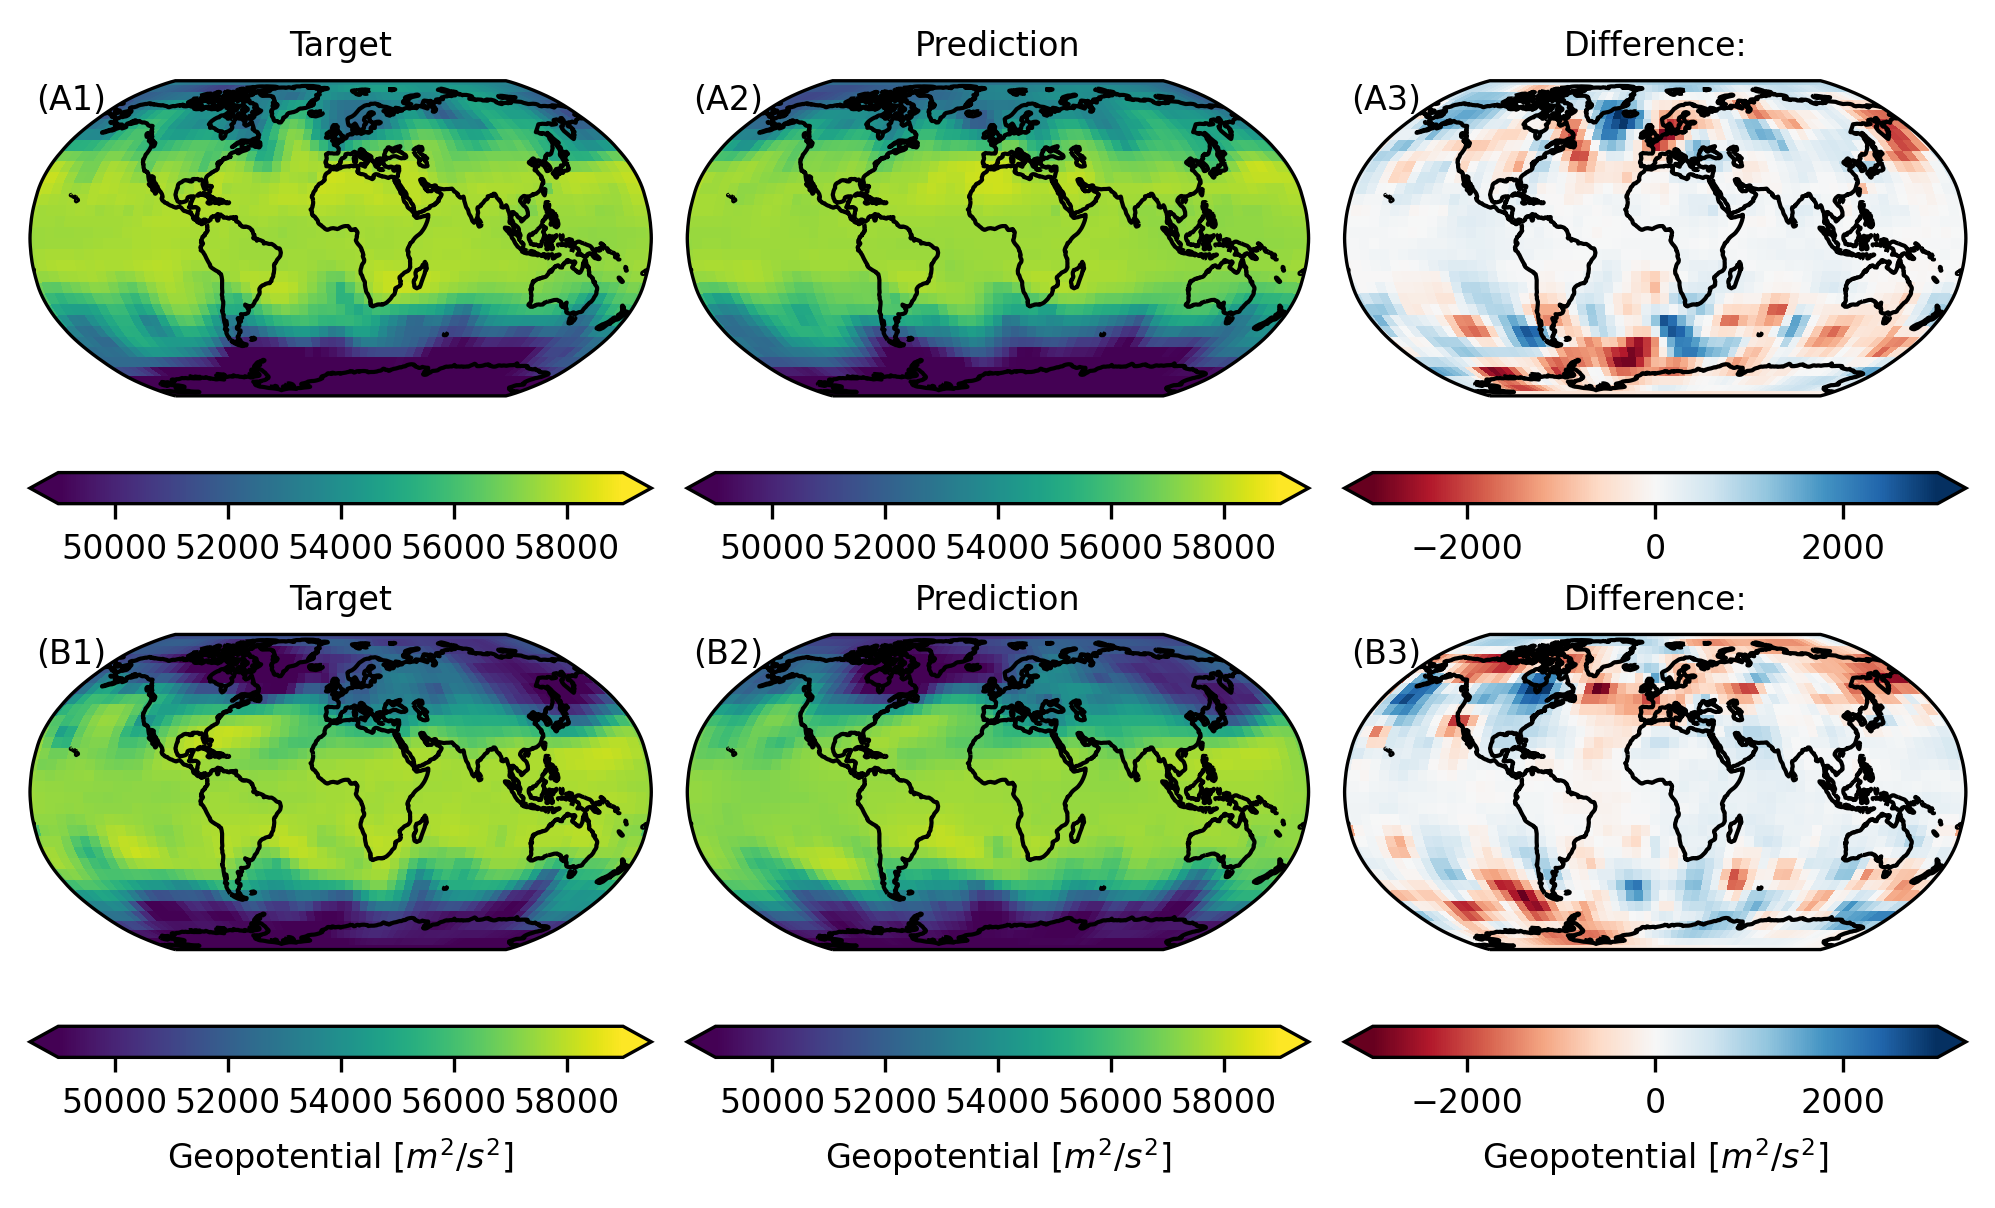

In [110]:
n_rows = n_images
n_cols = 3

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1,1,1])

for i, i_t in enumerate(timesteps):
    if i == n_rows - 1:
        config["SHOW_COLORBAR_LABEL"] = True
        config_diff["SHOW_COLORBAR_LABEL"] = True
    else:
        config["SHOW_COLORBAR_LABEL"] = False
        config_diff["SHOW_COLORBAR_LABEL"] = False

    ax = fig.add_subplot(gs[i, 0], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=targets.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(targets.keys())], plotting_config=config, title="Target")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}1)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 1], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=predictions.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(predictions.keys())], plotting_config=config, title="Prediction")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}2)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 2], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=diff.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(diff.keys())], plotting_config=config_diff, title="Difference:")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}3)".format(alphabet_letters[i]))


fig.canvas.draw()
fig.tight_layout()

plt.savefig("/home/wider/Projects/diffusion-models-for-weather-prediction/images/predictions.jpg")

### Ensemble plot

In [111]:
ds_cond = xr.open_mfdataset("/data/compoundx/WeatherBench/geopotential_500/*.nc")

In [112]:
predictions_experiments[model_id].init_time[i_random]

<xarray.DataArray 'init_time' ()>
array('2018-09-29T18:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    init_time  datetime64[ns] 2018-09-29T18:00:00

In [113]:
cond_data = ds_cond.sel({"time": predictions_experiments[model_id].init_time[i_random]})

In [115]:
config["SHOW_COLORBAR"] = False

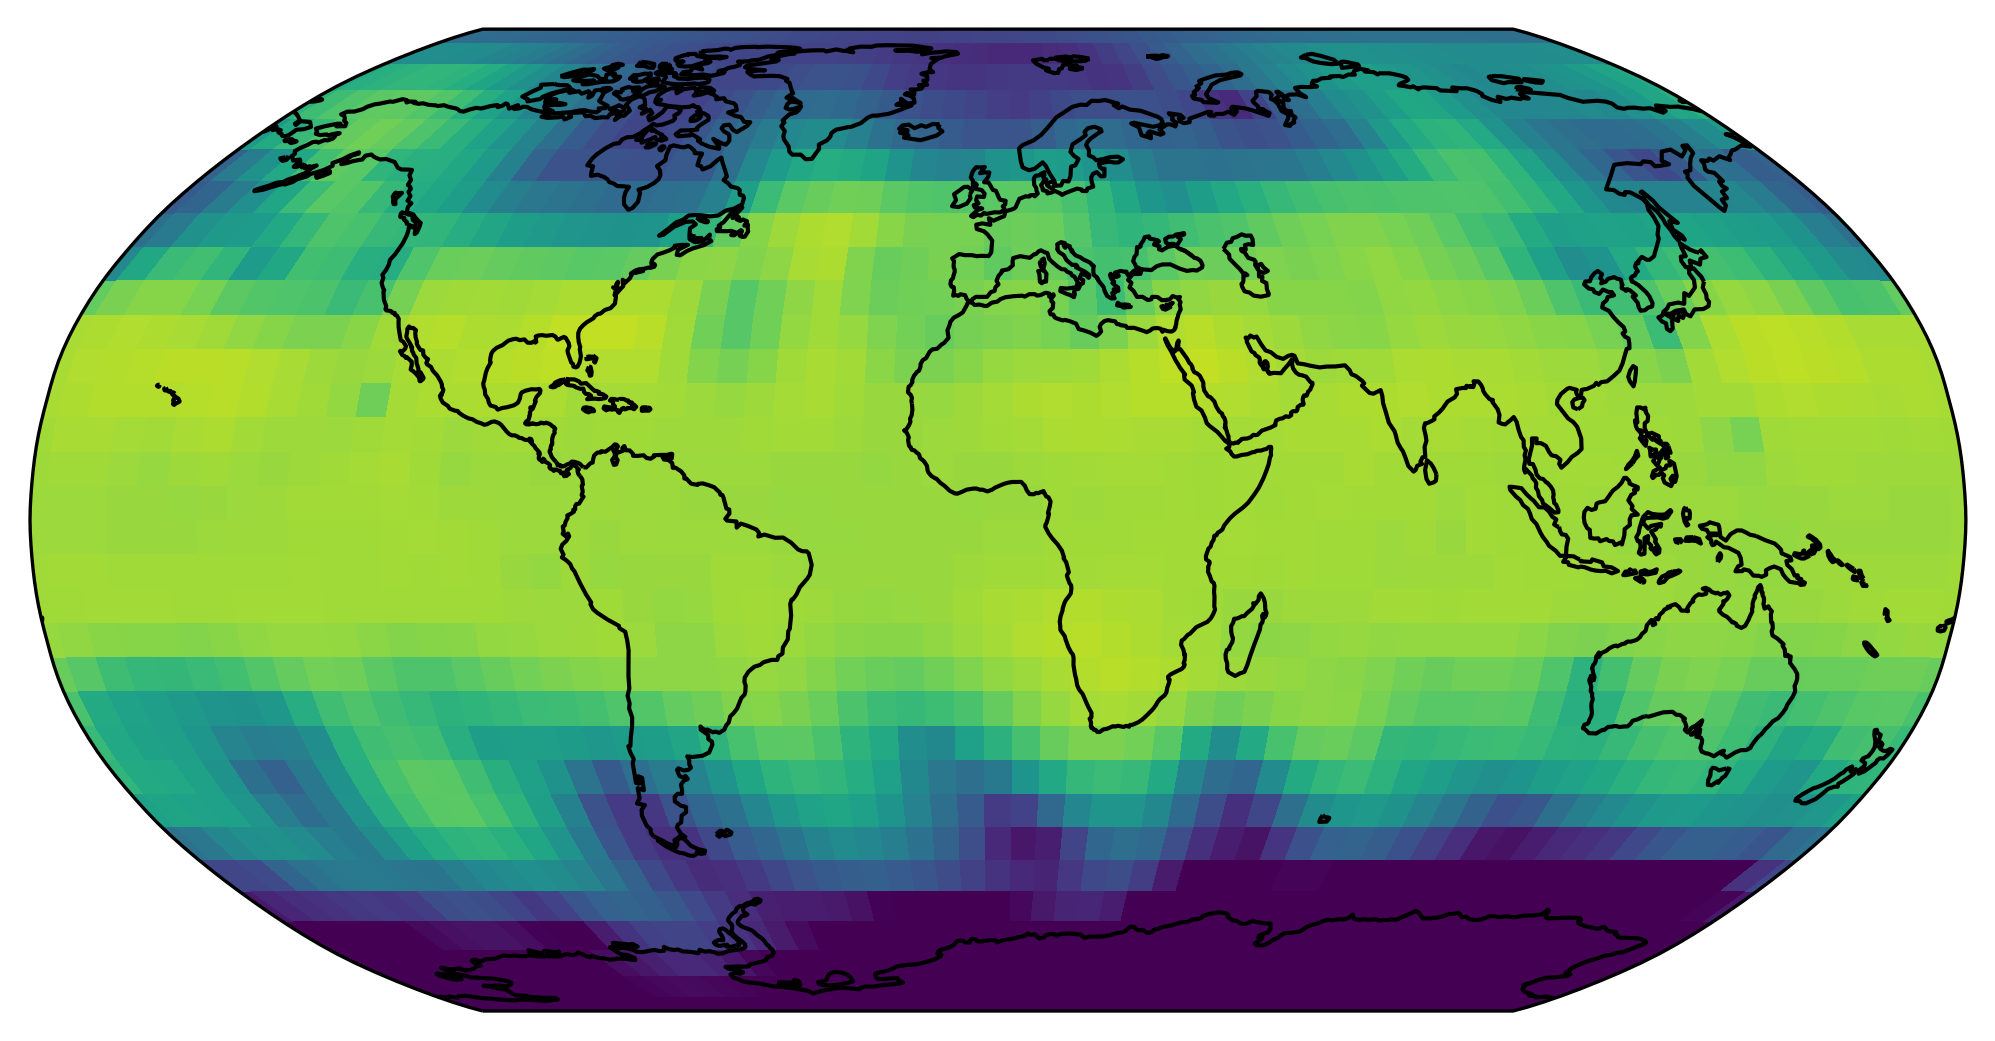

In [155]:
n_rows = 1
n_cols = 1

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1])

if i == n_rows - 1:
    config["SHOW_COLORBAR_LABEL"] = True
    config_diff["SHOW_COLORBAR_LABEL"] = True
else:
    config["SHOW_COLORBAR_LABEL"] = False
    config_diff["SHOW_COLORBAR_LABEL"] = False

ax = fig.add_subplot(gs[0, 0], projection=config["PROJECTION"])
# plot the map:
plot_map(ax, data=cond_data, plotting_config=config)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("/home/wider/Projects/diffusion-models-for-weather-prediction/images/ensemble_condition.jpg")

In [156]:
config["ASPECT_RATIO"] = 9/5

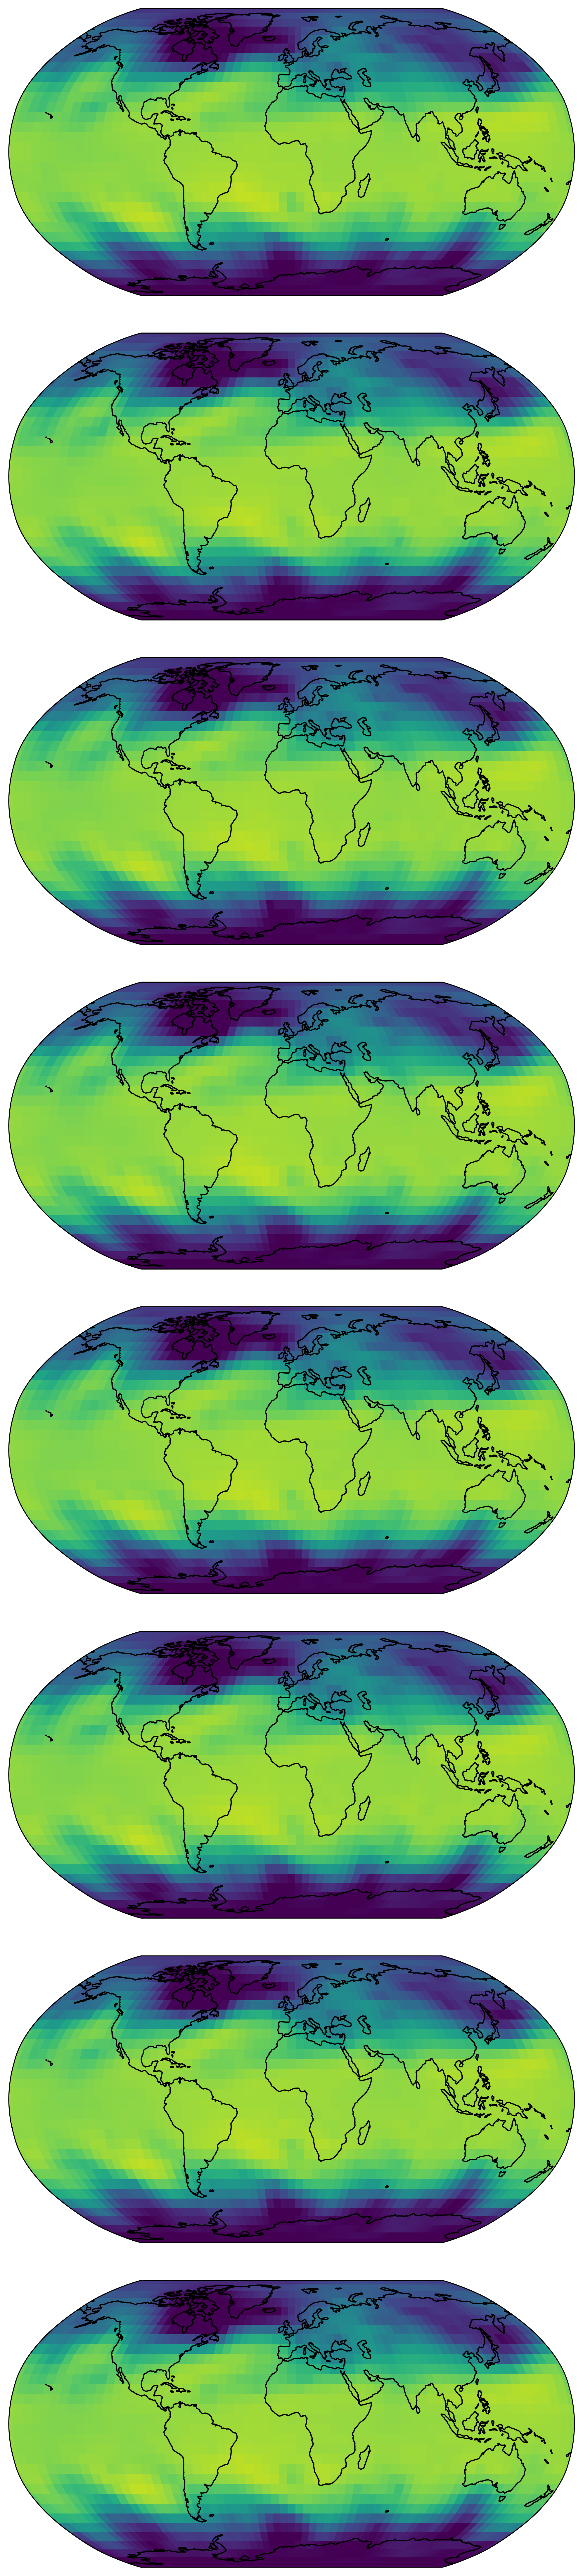

In [157]:
n_rows = len(predictions.ensemble_member)
n_cols = 1

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1])
for i in range(8):
    if i == n_rows - 1:
        config["SHOW_COLORBAR_LABEL"] = True
        config_diff["SHOW_COLORBAR_LABEL"] = True
    else:
        config["SHOW_COLORBAR_LABEL"] = False
        config_diff["SHOW_COLORBAR_LABEL"] = False

    ax = fig.add_subplot(gs[i, 0], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=predictions.isel({"init_time":i_t, "lead_time":0, "ensemble_member": i})[list(diff.keys())], plotting_config=config)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("/home/wider/Projects/diffusion-models-for-weather-prediction/images/ensemble_predictions.jpg")

In [171]:
config_std = copy.deepcopy(config)

config_std["CMAP"] = "Blues"
config_std["NORM"] = matplotlib.colors.Normalize(vmin=0, vmax=300)
config_std["SHOW_COLORBAR"] = True
config_std["SHOW_COLORBAR_LABEL"] = True
config_std["CBAR_EXTEND"] = "max"
config_std["CBAR_LABEL"] = r"$\sigma_{Geopotential}$ [$m^2/s^2$]"

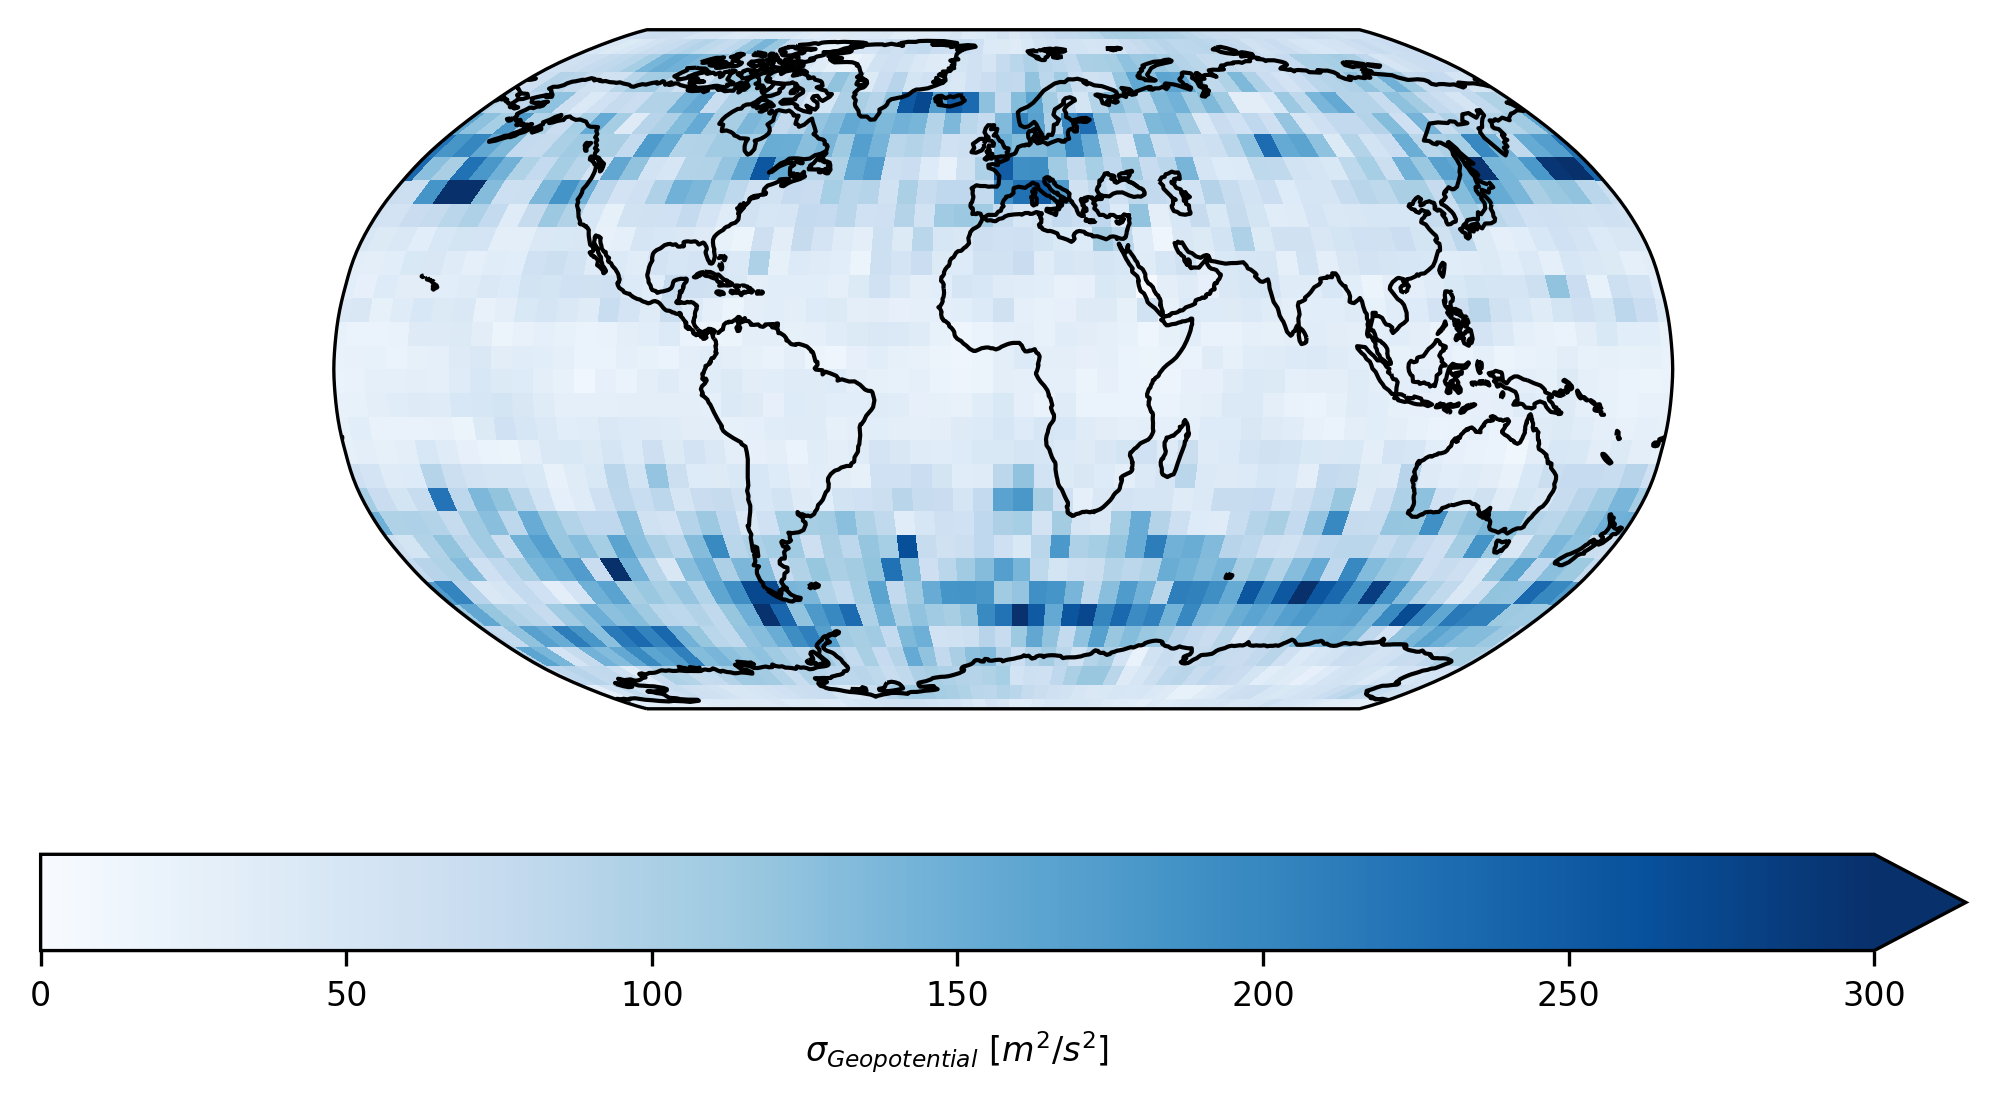

In [172]:
n_rows = 1
n_cols = 1

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1])

if i == n_rows - 1:
    config["SHOW_COLORBAR_LABEL"] = True
    config_diff["SHOW_COLORBAR_LABEL"] = True
else:
    config["SHOW_COLORBAR_LABEL"] = False
    config_diff["SHOW_COLORBAR_LABEL"] = False

ax = fig.add_subplot(gs[0, 0], projection=config["PROJECTION"])
# plot the map:
plot_map(ax, data=predictions.isel({"init_time": i_random}).std(dim=("lead_time", "ensemble_member")), plotting_config=config_std)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("/home/wider/Projects/diffusion-models-for-weather-prediction/images/ensemble_std.jpg")